In [1]:
import iron56_end
import iron56_end_r
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pynucastro as pyna
from pynucastro.screening import potekhin_1998

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.rcParams['savefig.bbox']='tight'

## Integrating the `iron56_end` network

We will start with the definitions of three important functions: `plot`, `composition`, and `plot_ye`. The first function plots the reaction network (RN) molar fraction abundances integration vs time. The `composition` setup the initial mass fraction $\mathbf{Y_0}$ required by the integrator. Finally `plot_ye` plots the elctron mass fraction $Y_e$ vs time. Since no weak reactions are included in our RN, the electron mass fraction should remain constant. This fact allow us to verify if the reaction network integration is performed correctly.  

In [2]:
def plot(tmin, tmax, sol, network, outfile='test'):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    for i in range(network.nnuc):
        ax.loglog(sol.t, sol.y[i,:] * network.A[i], label=rf"X(${pyna.Nucleus(network.names[i]).pretty}$)")

    ax.set_xlim(tmin, tmax)
    ax.set_ylim(1.e-10, 1.0)
    ax.legend(fontsize="small")
    ax.set_xlabel(f"time (s)")
    ax.set_ylabel(f"Mass Fraction")

    fig.set_size_inches((10, 8))
    fig.tight_layout()
    fig.savefig(outfile, bbox_inches="tight")

def composition(network):
    
    X0 = np.zeros(network.nnuc)
    X0[network.jco55] = 0.0
    X0[network.jn] = 1.0
    X0[network.jcr48] = 3.4
    X0[network.jfe52] = 0.0
    X0[network.jhe4] = 1.0
    X0[network.jmn51] = 0.0
    X0[network.jni56] = 1.0
    X0[network.jcr56] = 0.0
    X0[network.jfe54] = 0.0
    X0[network.jfe55] = 0.0
    X0[network.jfe56] = 0.0
    X0[network.jmn56] = 0.0
    X0[network.jp] = 1.0
    X0[network.jfe53] = 0.0
    X0[network.jmn52] = 0.0
    X0[network.jco56] = 0.0
    X0[network.jcr49] = 0.0
    
    X0[network.jmn55] = 0.0
    X0[network.jmn54] = 0.0
    X0[network.jmn53] = 0.0
    X0[network.jcr55] = 0.0
    
    
    X0 /= np.sum(X0)
    Y0 = X0/network.A

    return Y0

def plot_ye(tmin, tmax, sol, network, outfile='test'):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    y_e = np.zeros_like(sol.t)
    for i in range(network.nnuc):
        y_e += sol.y[i,:] * network.Z[i]

    ax.plot(sol.t, y_e, label=rf"$Y_e = {y_e[0]:.3f}$")
    ax.set_xscale('log')
    ax.set_xlim(tmin, tmax)
    ax.set_ylim(0.0, 1.0)
    ax.legend(fontsize="small")
    ax.set_xlabel("time (s)")
    ax.set_ylabel("Electron Mass Fraction")

    fig.set_size_inches((10, 8))
    fig.tight_layout()
    fig.savefig(outfile, bbox_inches="tight")

    

Now, using `composite` we setup the initial conditions, by providing $(\rho, T)$.

In [3]:
Y0 = composition(iron56_end)
rho = 1.0e8
T = 7.0e9
ye = iron56_end.ye(Y0)

and integrate the `iron56_end.py` stiff ODE system by using the BDF method, and plot the electron mass fraction with `plot_ye`.

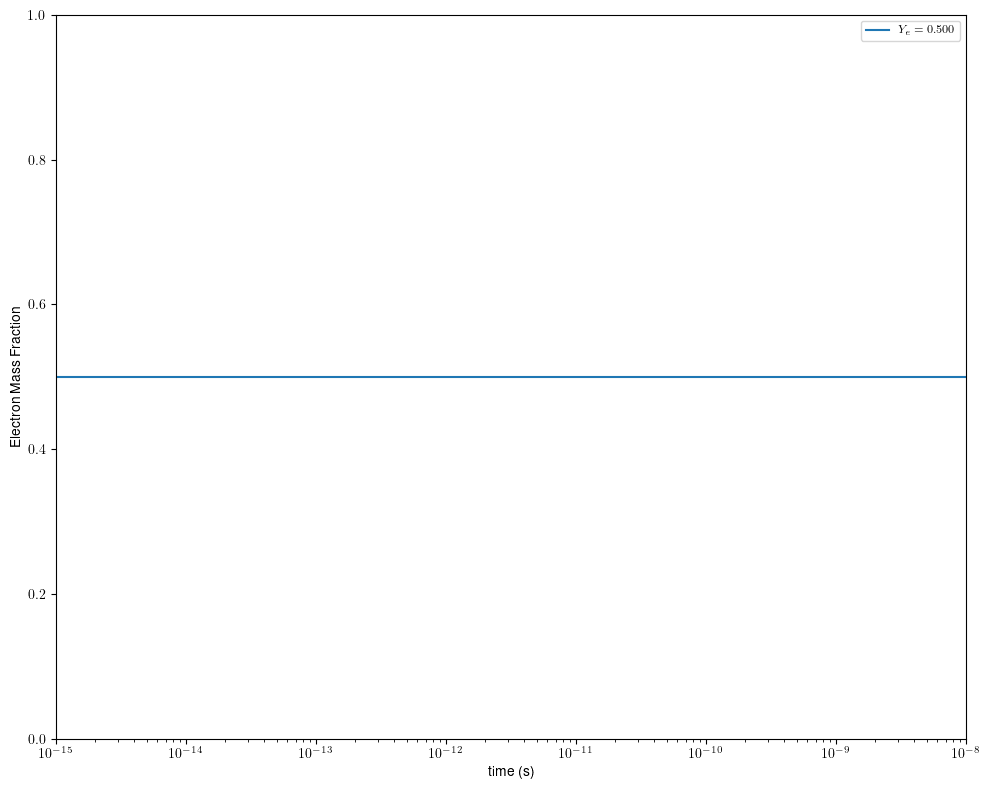

In [4]:
tmax = 1.0e-8
tmin = 1.0e-15

sol =  solve_ivp(iron56_end.rhs, [0, tmax], Y0, method="BDF",
                dense_output=True, args=(rho, T, potekhin_1998), rtol=1.e-10, atol=1.e-10, jac=iron56_end.jacobian)

plot_ye(tmin=tmin, tmax=tmax, sol=sol, network=iron56_end, outfile='rho_{:.2e}_T_{:.2e}_ye_{:.2e}.png'.format(rho,T, ye))

Plotting the `iron56_end.py` mass fractions, by using `plot`:

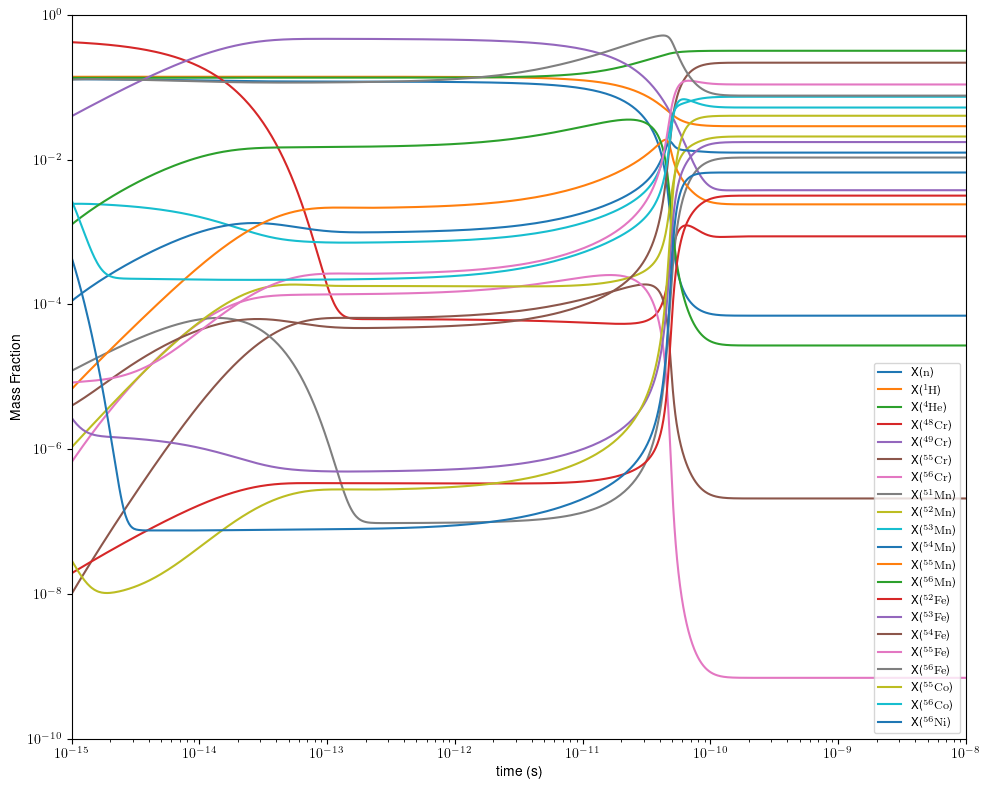

In [5]:
plot(tmin=tmin, tmax=tmax, sol=sol, network=iron56_end, outfile='rho_{:.2e}_T_{:.2e}.png'.format(rho,T))

# Checking the NSE state

Now, we want to compute the NSE state, characterized by $(\rho, T, Y_e)$. We start by creating the `RateCollection` python network again.

In [6]:
# Find NSE composition to compare with integration route:

all_reactions = pyna.ReacLibLibrary()
fwd_reactions = all_reactions.derived_forward()

all_nuclei = ['n', 'p', 'he4', 'cr48', 'cr49', 'cr55', 'cr56', 'mn51', 
              'mn52', 'mn53', 'mn54', 'mn55',  'mn56', 'fe52', 'fe53', 
              'fe54', 'fe55', 'fe56', 'co55', 'co56', 'ni56']

fwd_rates_lib = fwd_reactions.linking_nuclei(nuclist=all_nuclei, with_reverse=False)

derived = []
for r in fwd_rates_lib.get_rates():
    d = pyna.DerivedRate(rate=r, compute_Q=False, use_pf=True)
    derived.append(d)

der_rates_lib = pyna.Library(rates=derived)
full_library = fwd_rates_lib + der_rates_lib

rc = pyna.RateCollection(libraries=full_library)

Now we create a bar plot by picking the network final time value and compare it to the NSE computed values  

In [7]:
comp = rc.get_comp_nse(rho, T, ye, init_guess=(-3.5, -14.0), use_coulomb_corr=True)

print("From NSE calculation:")
print(comp)
# for key, value in comp.items():
#     print(key, ":", value)

print(" ")

print("From integration:")
for i in range(iron56_end.nnuc):
    print(f"X({iron56_end.names[i]}): {sol.y[i,-1]*iron56_end.A[i]}")

From NSE calculation:
  X(n) : 7.10415866355107e-05
  X(p) : 0.029371242429682084
  X(he4) : 0.31074702509562424
  X(cr48) : 0.0009317560331415512
  X(cr49) : 0.004007715822205178
  X(cr55) : 2.1055875374439688e-07
  X(cr56) : 6.839739438411525e-10
  X(mn51) : 0.011160053950942356
  X(mn52) : 0.021597556697359875
  X(mn53) : 0.07589626741174446
  X(mn54) : 0.012740059208619262
  X(mn55) : 0.0024352425031564907
  X(mn56) : 2.7134260141759718e-05
  X(fe52) : 0.0032778299467872063
  X(fe53) : 0.017966971882857383
  X(fe54) : 0.22250931778155594
  X(fe55) : 0.11034490777472375
  X(fe56) : 0.07680272155754721
  X(co55) : 0.04086397488065593
  X(co56) : 0.052558221077919284
  X(ni56) : 0.0066907488559253036

 
From integration:
X(n): 7.007963228358705e-05
X(h1): 0.029018985100811027
X(he4): 0.31986311541737444
X(cr48): 0.0008738270902518454
X(cr49): 0.0037903098834718182
X(cr55): 2.092327144910449e-07
X(cr56): 6.964369769486244e-10
X(mn51): 0.010718250697033116
X(mn52): 0.02093127502438969
X

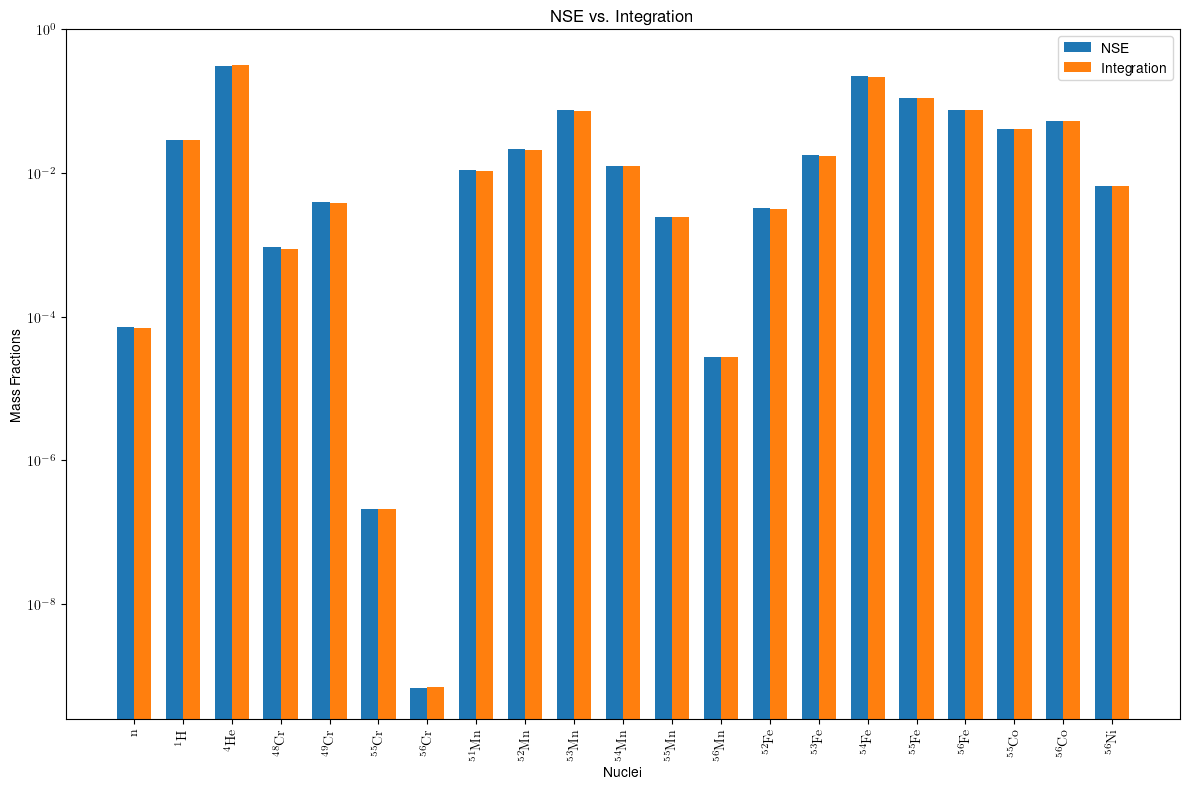

In [8]:
# Bar graph for visual

x = np.arange(len(iron56_end.names))
width = 0.35

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.bar(x - width/2.0, list(comp.X.values()), width, label = 'NSE')
ax.bar(x + width/2.0, sol.y[:,-1]*iron56_end.A, width, label = 'Integration')
ax.set_xlabel("Nuclei")
ax.set_xticks(x, labels=[f"${n.pretty}$" for n in comp.X.keys()], rotation=90)
ax.set_ylabel("Mass Fractions")
ax.set_yscale("log")
ax.set_title("NSE vs. Integration")
ax.set_ylim(ymax = 1)
ax.legend()

plt.tight_layout()
fig.savefig('nse_network_comparison.pdf', bbox_inches="tight")

Similarly, we can plot the absolute and relative differences

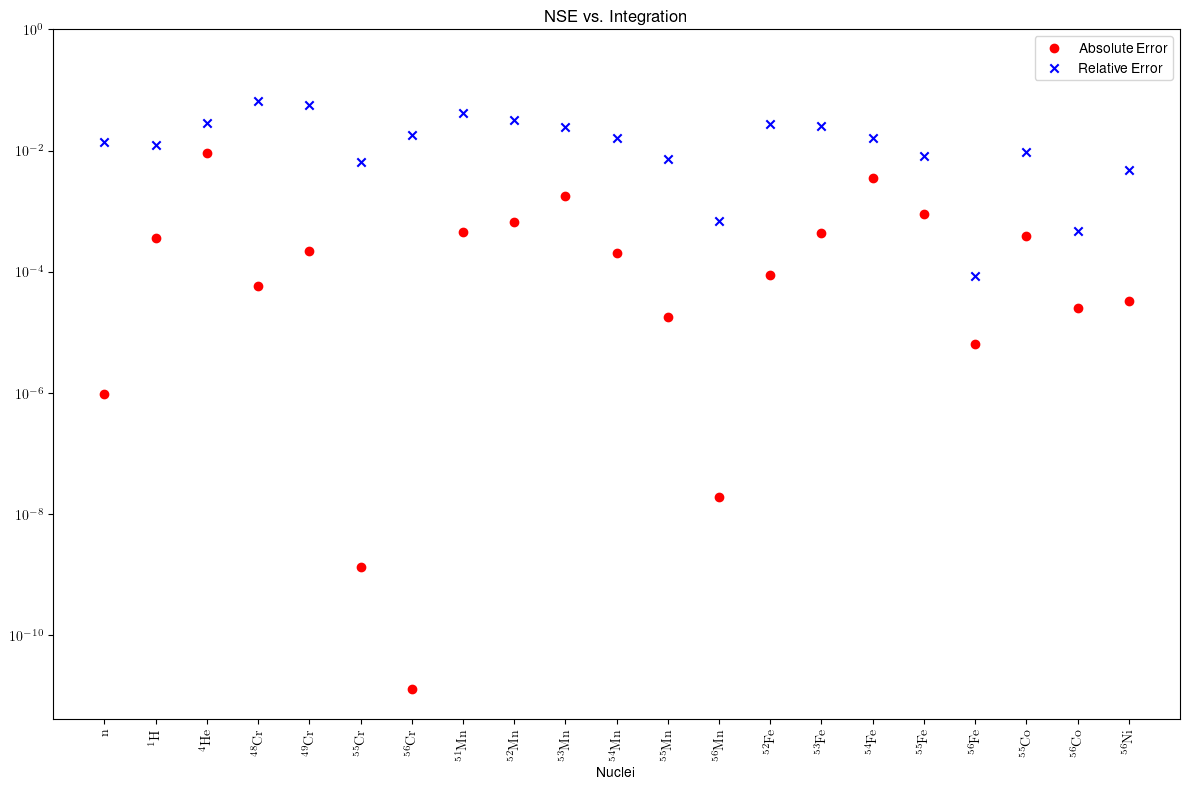

In [9]:
# Difference graph
X_net = {}

for i in range(iron56_end.nnuc):
    X_net[pyna.Nucleus(iron56_end.names[i])] = sol.y[i,-1]*iron56_end.A[i]

X_nse = comp.X

diff = {}
diff_rel = {}

for i in range(iron56_end.nnuc):
    nuc = pyna.Nucleus(iron56_end.names[i])
    diff[nuc] = np.abs(X_net[nuc] - X_nse[nuc])
    diff_rel[nuc] = np.abs(X_net[nuc] - X_nse[nuc])/X_net[nuc]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(x, diff.values(), label='Absolute Error', marker='o', color='r')
ax.scatter(x, diff_rel.values(), label='Relative Error', marker ='x', color='b')
ax.set_xticks(x, labels=[f"${n.pretty}$" for n in diff.keys()], rotation=90)
ax.set_xlabel("Nuclei")
ax.set_yscale("log")
ax.set_title("NSE vs. Integration")
ax.set_ylim(ymax = 1)
ax.legend()

fig.tight_layout()
fig.savefig("nse_vs_network_2.pdf", bbox_inches="tight")